# Pipeline de Entrenamiento de Fictitious Play y Regret Matching

Este notebook entrena agentes de Fictitious Play (FP) y Regret Matching (RM) para el entorno Foraging.
Estos agentes aprenden jugando entre sí durante múltiples episodios.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time

from games.foraging import Foraging
from agents.fictitiousplay_t import FictitiousPlay
from agents.regretmatching_t import RegretMatching
from agents.random_agent import RandomAgent
from base.agent import Agent
from base.game import SimultaneousGame, AgentID, ActionDict

## 1. Configuraciones del Juego y Loop de Entrenamiento

Configuración del entrenamiento para múltiples juegos para coincidir con la estructura del pipeline de entrenamiento IQL.

In [ ]:
games_to_test = [
    {"name": "RPS", "game_class": "RPS", "config": {}, "train_episodes": 1000, "max_steps": 1},
    {"name": "MP", "game_class": "MP", "config": {}, "train_episodes": 1000, "max_steps": 1},
    {"name": "Blotto_S10_N5", "game_class": "Blotto", "config": {"S": 10, "N": 5}, "train_episodes": 2000, "max_steps": 1},
    {"name": "Foraging_5x5_2p_3f", "game_class": "Foraging", "config": {"config": "Foraging-5x5-2p-3f-v3", "seed": 123}, "train_episodes": 2000, "max_steps": 200}
]

CURRENT_GAME = games_to_test[3]
GAME_CONFIG = CURRENT_GAME["config"]["config"]
GAME_NAME = CURRENT_GAME["name"]
SEED = CURRENT_GAME["config"]["seed"]

TRAINING_EPISODES = CURRENT_GAME["train_episodes"]
MAX_STEPS_PER_EPISODE = CURRENT_GAME["max_steps"]

print(f"Configuración de entrenamiento para {GAME_NAME}:")
print(f"  Episodios: {TRAINING_EPISODES}")
print(f"  Máx pasos por episodio: {MAX_STEPS_PER_EPISODE}")
print(f"  Config del juego: {GAME_CONFIG}")
print(f"  Seed: {SEED}")

FP_TRAINING_DIR = "fp_trainings"
RM_TRAINING_DIR = "rm_trainings"

for dir_name in [FP_TRAINING_DIR, RM_TRAINING_DIR]:
    game_specific_path = os.path.join(dir_name, GAME_NAME)
    if not os.path.exists(game_specific_path):
        os.makedirs(game_specific_path)
        print(f"Directorio creado: {game_specific_path}")
    else:
        print(f"El directorio ya existe: {game_specific_path}")

Training configuration for Foraging_5x5_2p_3f:
  Episodes: 2000
  Max steps per episode: 200
  Game config: Foraging-5x5-2p-3f-v3
  Seed: 123
Directory already exists: fp_trainings/Foraging_5x5_2p_3f
Directory already exists: rm_trainings/Foraging_5x5_2p_3f


## 2. Funciones de Ayuda para Creación de Juegos

Definir funciones utilitarias para crear instancias de juegos desde la configuración.

In [ ]:
def get_game_instance(game_entry: dict) -> SimultaneousGame:
    """Crear una instancia de juego desde una entrada de juego."""
    from games.rps import RPS
    from games.mp import MP
    from games.blotto import Blotto
    from games.foraging import Foraging
    
    game_classes = {
        "RPS": RPS,
        "MP": MP,
        "Blotto": Blotto,
        "Foraging": Foraging
    }
    
    game_class = game_classes[game_entry["game_class"]]
    config = game_entry["config"]
    
    if game_entry["game_class"] in ["Blotto", "Foraging"]:
        return game_class(**config)
    else:
        return game_class()

def play_episode(game: SimultaneousGame, agents: dict[AgentID, Agent], max_steps: int = 100, verbose: bool = False):
    """Jugar un episodio con los agentes dados."""
    game.reset()
    cumulative_rewards = {agent_id: 0.0 for agent_id in game.agents}
    
    is_foraging = hasattr(game, 'env') and hasattr(game.env, 'unwrapped')
    
    for step in range(max_steps):
        if is_foraging and hasattr(game.env.unwrapped, '_game_over') and game.env.unwrapped._game_over:
            break
        if not is_foraging and all(game.terminations.values()):
            break
            
        action_dict = {}
        for agent_id in game.agents:
            action = agents[agent_id].action()
            action_dict[agent_id] = action
        
        game.step(action_dict)
        
        for agent_id in game.agents:
            reward = game.reward(agent_id)
            
            if isinstance(reward, list):
                reward = float(sum(reward))
            
            cumulative_rewards[agent_id] += reward
            
            if hasattr(agents[agent_id], 'update'):
                agents[agent_id].update()
        
        if verbose and step < 10:
            print(f"  Paso {step}: Acciones: {action_dict}, Recompensas: {cumulative_rewards}")
            
        if all(game.terminations.values()) or (is_foraging and hasattr(game.env.unwrapped, '_game_over') and game.env.unwrapped._game_over):
            break
    
    return cumulative_rewards

def train_agents(game: SimultaneousGame, agents: dict[AgentID, Agent], episodes: int, agent_type: str, max_steps: int = 100):
    """Entrenar los agentes por el número especificado de episodios."""
    print(f"\nComenzando entrenamiento {agent_type} por {episodes} episodios...")
    
    all_rewards = {agent_id: [] for agent_id in game.agents}
    
    for episode in range(episodes):
        episode_rewards = play_episode(game, agents, max_steps)
        
        for agent_id in game.agents:
            all_rewards[agent_id].append(episode_rewards[agent_id])
        
        progress_interval = max(1, episodes // 10)
        if (episode + 1) % progress_interval == 0:
            avg_rewards = {agent_id: np.mean(all_rewards[agent_id][-100:]) for agent_id in game.agents}
            print(f"  Episodio {episode + 1}/{episodes}: Recompensas promedio (últimos 100): {avg_rewards}")
    
    print(f"Entrenamiento {agent_type} completado.")
    return all_rewards

## 3. Funciones de Guardado

Funciones para guardar los modelos de agentes entrenados.

In [ ]:
def save_fp_agent(agent: FictitiousPlay, game_name: str, agent_idx: int, base_path: str):
    """Guardar conteos del agente Fictitious Play."""
    game_specific_path = os.path.join(base_path, game_name)
    counts_path = os.path.join(game_specific_path, f'agent_{agent_idx}_fp_counts.pkl')
    
    try:
        with open(counts_path, 'wb') as f:
            pickle.dump(agent.count, f)
        print(f"  Conteos del agente FP {agent_idx} guardados en {counts_path}")
    except Exception as e:
        print(f"  Error guardando agente FP {agent_idx}: {e}")

def save_rm_agent(agent: RegretMatching, game_name: str, agent_idx: int, base_path: str):
    """Guardar policy del agente Regret Matching."""
    game_specific_path = os.path.join(base_path, game_name)
    policy_path = os.path.join(game_specific_path, f'agent_{agent_idx}_rm_policy.pkl')
    
    try:
        with open(policy_path, 'wb') as f:
            pickle.dump(agent.learned_policy, f)
        print(f"  Policy del agente RM {agent_idx} guardada en {policy_path}")
    except Exception as e:
        print(f"  Error guardando agente RM {agent_idx}: {e}")

def save_training_rewards(rewards: dict, game_name: str, base_path: str, filename: str):
    """Guardar historial de recompensas de entrenamiento."""
    game_specific_path = os.path.join(base_path, game_name)
    rewards_path = os.path.join(game_specific_path, filename)
    
    try:
        with open(rewards_path, 'wb') as f:
            pickle.dump(rewards, f)
        print(f"  Recompensas de entrenamiento guardadas en {rewards_path}")
    except Exception as e:
        print(f"  Error guardando recompensas de entrenamiento: {e}")

## 4. Loop de Entrenamiento Comprensivo

Entrenar agentes FP y RM para todos los juegos para coincidir con el pipeline de entrenamiento IQL.

In [ ]:
print("=== ENTRENANDO AGENTES FICTITIOUS PLAY Y REGRET MATCHING ===")

for game_entry in games_to_test:
    game_name = game_entry["name"]
    train_episodes = game_entry["train_episodes"]
    max_steps = game_entry["max_steps"]
    
    print(f"\n--- Entrenando para el juego: {game_name} ---")
    print(f"Episodios: {train_episodes}, Máx pasos por episodio: {max_steps}")
    
    game_instance = get_game_instance(game_entry)
    print(f"Juego creado: {game_instance.__class__.__name__}")
    print(f"Agentes: {game_instance.agents}")
    
    print(f"\n=== ENTRENANDO AGENTES FICTITIOUS PLAY PARA {game_name} ===")
    
    fp_agents = {}
    for agent_id in game_instance.agents:
        fp_agents[agent_id] = FictitiousPlay(game=game_instance, agent=agent_id, seed=123)
    
    print(f"Creados {len(fp_agents)} agentes FP")
    
    fp_rewards = train_agents(game_instance, fp_agents, train_episodes, "Fictitious Play", max_steps)
    
    print(f"\nGuardando agentes FP para {game_name}...")
    for i, (agent_id, agent) in enumerate(fp_agents.items()):
        save_fp_agent(agent, game_name, i, FP_TRAINING_DIR)
    
    save_training_rewards(fp_rewards, game_name, FP_TRAINING_DIR, 'fp_training_rewards.pkl')
    print(f"Entrenamiento y guardado FP completado para {game_name}.")
    
    print(f"\n=== ENTRENANDO AGENTES REGRET MATCHING PARA {game_name} ===")
    
    rm_game_instance = get_game_instance(game_entry)
    
    rm_agents = {}
    for agent_id in rm_game_instance.agents:
        rm_agents[agent_id] = RegretMatching(game=rm_game_instance, agent=agent_id, seed=123)
    
    print(f"Creados {len(rm_agents)} agentes RM")
    
    rm_rewards = train_agents(rm_game_instance, rm_agents, train_episodes, "Regret Matching", max_steps)
    
    print(f"\nGuardando agentes RM para {game_name}...")
    for i, (agent_id, agent) in enumerate(rm_agents.items()):
        save_rm_agent(agent, game_name, i, RM_TRAINING_DIR)
    
    save_training_rewards(rm_rewards, game_name, RM_TRAINING_DIR, 'training_rewards_rm.pkl')
    print(f"Entrenamiento y guardado RM completado para {game_name}.")
    
    print(f"--- Entrenamiento completado para {game_name} ---")

print("\n=== TODO EL ENTRENAMIENTO COMPLETADO ===")

=== TRAINING FICTITIOUS PLAY AND REGRET MATCHING AGENTS ===

--- Training for game: RPS ---
Episodes: 1000, Max steps per episode: 1
Game created: RPS
Agents: ['agent_0', 'agent_1']

=== TRAINING FICTITIOUS PLAY AGENTS FOR RPS ===
Created 2 FP agents

Starting Fictitious Play training for 1000 episodes...
  Episode 100/1000: Avg rewards (last 100): {'agent_0': np.float64(0.0), 'agent_1': np.float64(0.0)}
  Episode 200/1000: Avg rewards (last 100): {'agent_0': np.float64(0.02), 'agent_1': np.float64(-0.02)}
  Episode 300/1000: Avg rewards (last 100): {'agent_0': np.float64(-0.12), 'agent_1': np.float64(0.12)}
  Episode 400/1000: Avg rewards (last 100): {'agent_0': np.float64(0.06), 'agent_1': np.float64(-0.06)}
  Episode 500/1000: Avg rewards (last 100): {'agent_0': np.float64(0.02), 'agent_1': np.float64(-0.02)}
  Episode 600/1000: Avg rewards (last 100): {'agent_0': np.float64(-0.02), 'agent_1': np.float64(0.02)}
  Episode 700/1000: Avg rewards (last 100): {'agent_0': np.float64(-0.06

/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


  Episode 200/2000: Avg rewards (last 100): {'agent_0': np.float64(0.01), 'agent_1': np.float64(0.01)}
  Episode 400/2000: Avg rewards (last 100): {'agent_0': np.float64(0.015), 'agent_1': np.float64(0.015)}
  Episode 400/2000: Avg rewards (last 100): {'agent_0': np.float64(0.015), 'agent_1': np.float64(0.015)}
  Episode 600/2000: Avg rewards (last 100): {'agent_0': np.float64(0.01), 'agent_1': np.float64(0.01)}
  Episode 600/2000: Avg rewards (last 100): {'agent_0': np.float64(0.01), 'agent_1': np.float64(0.01)}
  Episode 800/2000: Avg rewards (last 100): {'agent_0': np.float64(0.0025), 'agent_1': np.float64(0.0025)}
  Episode 800/2000: Avg rewards (last 100): {'agent_0': np.float64(0.0025), 'agent_1': np.float64(0.0025)}
  Episode 1000/2000: Avg rewards (last 100): {'agent_0': np.float64(0.0125), 'agent_1': np.float64(0.0125)}
  Episode 1000/2000: Avg rewards (last 100): {'agent_0': np.float64(0.0125), 'agent_1': np.float64(0.0125)}
  Episode 1200/2000: Avg rewards (last 100): {'agen

## 5. Análisis y Visualización del Entrenamiento

Graficar el progreso de entrenamiento para ambos tipos de agentes en todos los juegos.

In [ ]:
print("\n=== ENTRENANDO AGENTES REGRET MATCHING ===")

rm_game = Foraging(config=GAME_CONFIG, seed=SEED)
print(f"Juego creado: {rm_game.__class__.__name__}")
print(f"Agentes: {rm_game.agents}")

rm_agents = {}
for agent_id in rm_game.agents:
    rm_agents[agent_id] = RegretMatching(game=rm_game, agent=agent_id, seed=SEED)

print(f"Creados {len(rm_agents)} agentes RM")

rm_rewards = train_agents(rm_game, rm_agents, TRAINING_EPISODES, "Regret Matching")

print("\nGuardando agentes RM...")
for i, (agent_id, agent) in enumerate(rm_agents.items()):
    save_rm_agent(agent, GAME_NAME, i, RM_TRAINING_DIR)

save_training_rewards(rm_rewards, GAME_NAME, RM_TRAINING_DIR, 'training_rewards_rm.pkl')
print("Entrenamiento y guardado RM completado.")

def plot_training_results_for_game(game_name, fp_rewards, rm_rewards):
    """Graficar resultados de entrenamiento para un juego específico."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Progreso de Entrenamiento para {game_name}', fontsize=16)
    
    for i, (agent_id, rewards) in enumerate(fp_rewards.items()):
        if i < 2:
            window = min(100, len(rewards) // 10)
            if len(rewards) >= window and window > 1:
                moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
                axes[0, i].plot(moving_avg, label=f'FP {agent_id}')
            else:
                axes[0, i].plot(rewards, label=f'FP {agent_id}')
            axes[0, i].set_title(f'Recompensas Agente FP {i}')
            axes[0, i].set_xlabel('Episodio')
            axes[0, i].set_ylabel('Recompensa Promedio')
            axes[0, i].legend()
            axes[0, i].grid(True)
    
    for i, (agent_id, rewards) in enumerate(rm_rewards.items()):
        if i < 2:
            window = min(100, len(rewards) // 10)
            if len(rewards) >= window and window > 1:
                moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
                axes[1, i].plot(moving_avg, label=f'RM {agent_id}', color='orange')
            else:
                axes[1, i].plot(rewards, label=f'RM {agent_id}', color='orange')
            axes[1, i].set_title(f'Recompensas Agente RM {i}')
            axes[1, i].set_xlabel('Episodio')
            axes[1, i].set_ylabel('Recompensa Promedio')
            axes[1, i].legend()
            axes[1, i].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== RESULTADOS FINALES PARA {game_name} ===\n")
    fp_final_rewards = [np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards) for rewards in fp_rewards.values()]
    rm_final_rewards = [np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards) for rewards in rm_rewards.values()]
    print(f"Recompensas finales promedio FP: {fp_final_rewards}")
    print(f"Recompensas finales promedio RM: {rm_final_rewards}")

def load_and_plot_all_training_results():
    """Cargar y graficar resultados de entrenamiento para todos los juegos entrenados."""
    print("\n=== CARGANDO Y GRAFICANDO RESULTADOS DE ENTRENAMIENTO ===\n")
    
    for game_entry in games_to_test:
        game_name = game_entry["name"]
        
        fp_rewards_path = os.path.join(FP_TRAINING_DIR, game_name, 'fp_training_rewards.pkl')
        rm_rewards_path = os.path.join(RM_TRAINING_DIR, game_name, 'training_rewards_rm.pkl')
        
        if os.path.exists(fp_rewards_path) and os.path.exists(rm_rewards_path):
            print(f"Cargando resultados para {game_name}...")
            
            with open(fp_rewards_path, 'rb') as f:
                fp_rewards = pickle.load(f)
            
            with open(rm_rewards_path, 'rb') as f:
                rm_rewards = pickle.load(f)
            
            plot_training_results_for_game(game_name, fp_rewards, rm_rewards)
        else:
            print(f"Datos de entrenamiento no encontrados para {game_name}")
            print(f"  Datos FP existen: {os.path.exists(fp_rewards_path)}")
            print(f"  Datos RM existen: {os.path.exists(rm_rewards_path)}")


=== TRAINING REGRET MATCHING AGENTS ===
Game created: Foraging
Agents: ['agent_0', 'agent_1']
Created 2 RM agents

Starting Regret Matching training for 2000 episodes...
  Episode 200/2000: Avg rewards (last 100): {'agent_0': np.float64(0.02), 'agent_1': np.float64(0.02)}
  Episode 400/2000: Avg rewards (last 100): {'agent_0': np.float64(0.0125), 'agent_1': np.float64(0.0125)}
  Episode 600/2000: Avg rewards (last 100): {'agent_0': np.float64(0.0125), 'agent_1': np.float64(0.0125)}
  Episode 800/2000: Avg rewards (last 100): {'agent_0': np.float64(0.0075), 'agent_1': np.float64(0.0075)}
  Episode 400/2000: Avg rewards (last 100): {'agent_0': np.float64(0.0125), 'agent_1': np.float64(0.0125)}
  Episode 600/2000: Avg rewards (last 100): {'agent_0': np.float64(0.0125), 'agent_1': np.float64(0.0125)}
  Episode 800/2000: Avg rewards (last 100): {'agent_0': np.float64(0.0075), 'agent_1': np.float64(0.0075)}
  Episode 1000/2000: Avg rewards (last 100): {'agent_0': np.float64(0.015), 'agent_1

## 6. Cargar y Visualizar Todos los Resultados de Entrenamiento

Cargar y graficar resultados de entrenamiento para todos los juegos que han sido entrenados.

Found training data for 3 games: ['RPS', 'MP', 'Foraging_5x5_2p_3f']

Plotting results for RPS...


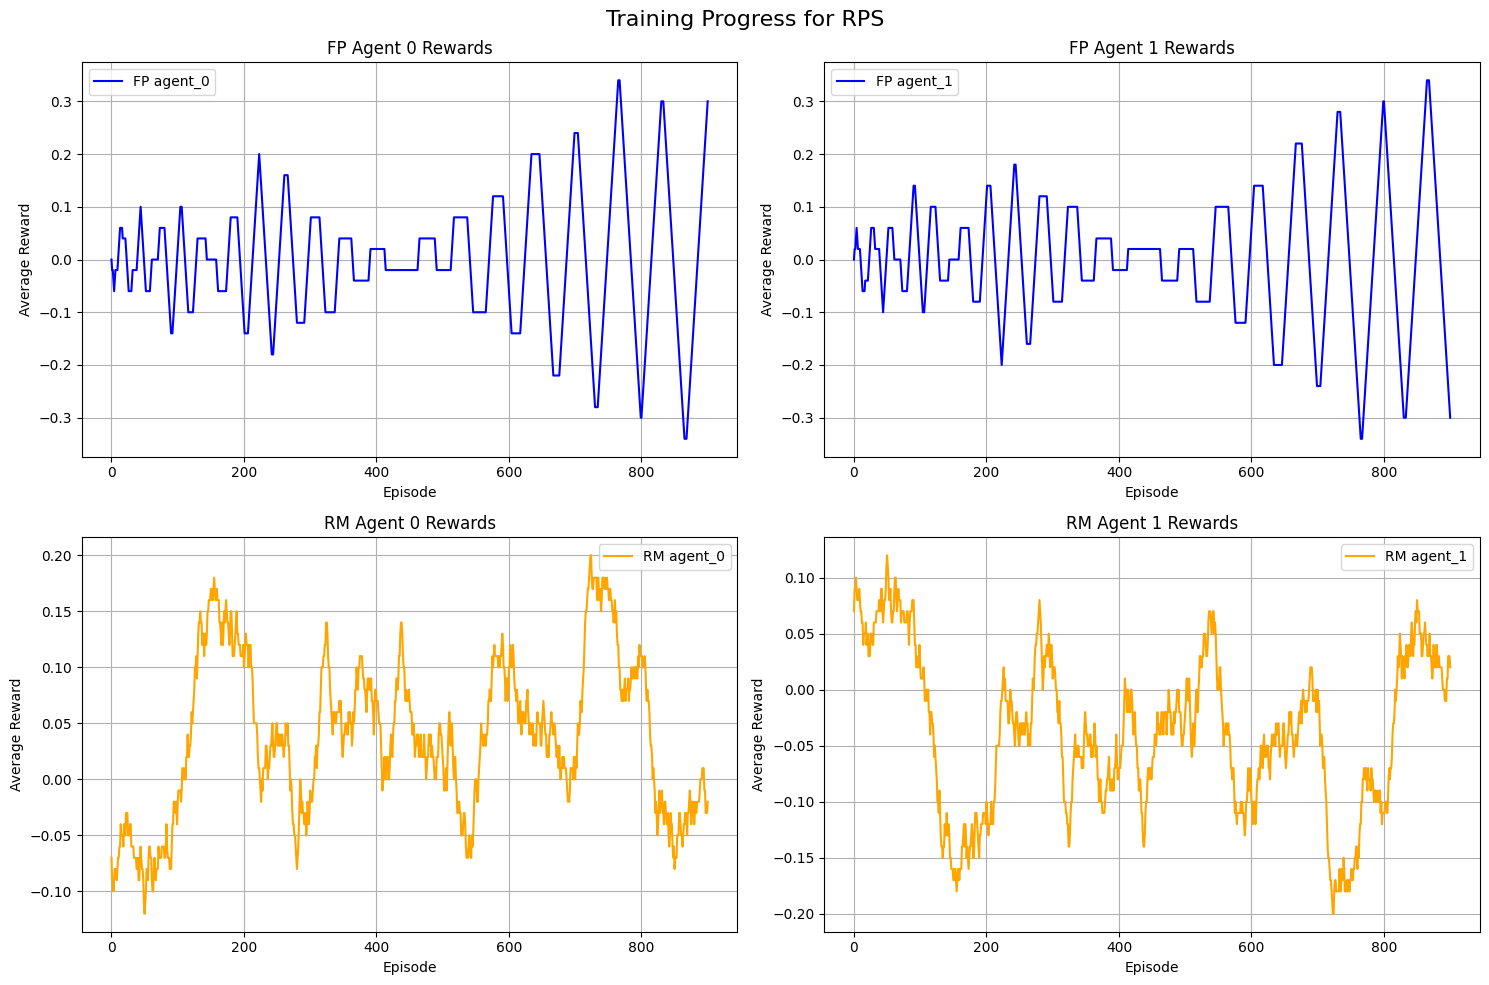


=== FINAL RESULTS FOR RPS ===

FP final average rewards: [np.float64(0.3), np.float64(-0.3)]
RM final average rewards: [np.float64(-0.02), np.float64(0.02)]

Plotting results for MP...


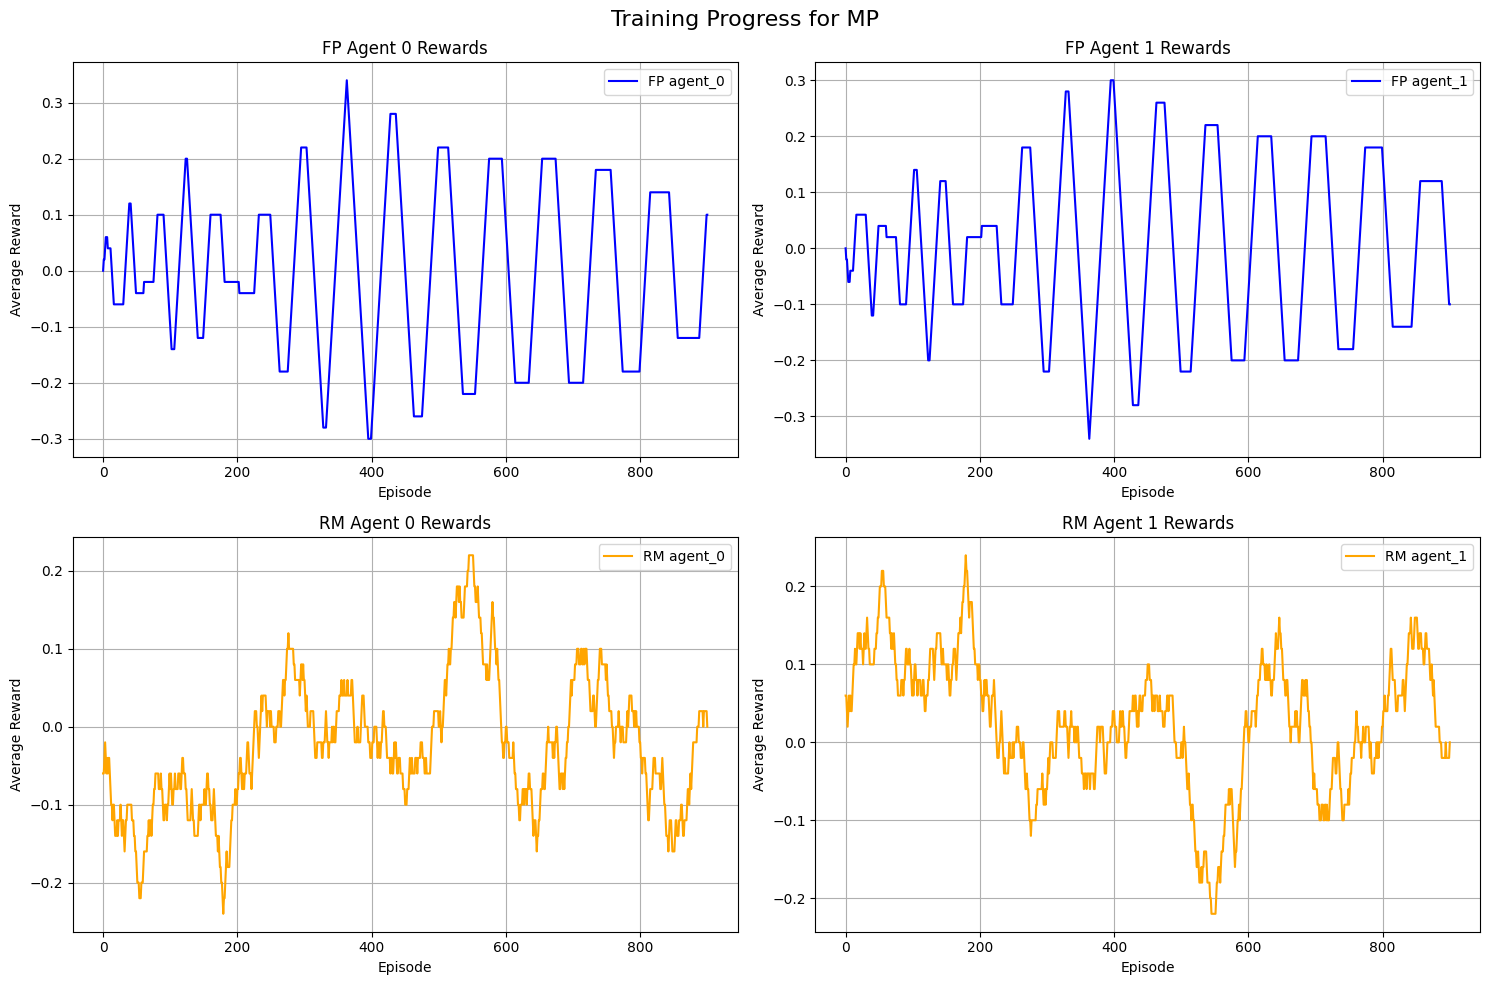


=== FINAL RESULTS FOR MP ===

FP final average rewards: [np.float64(0.1), np.float64(-0.1)]
RM final average rewards: [np.float64(0.0), np.float64(0.0)]

Plotting results for Foraging_5x5_2p_3f...


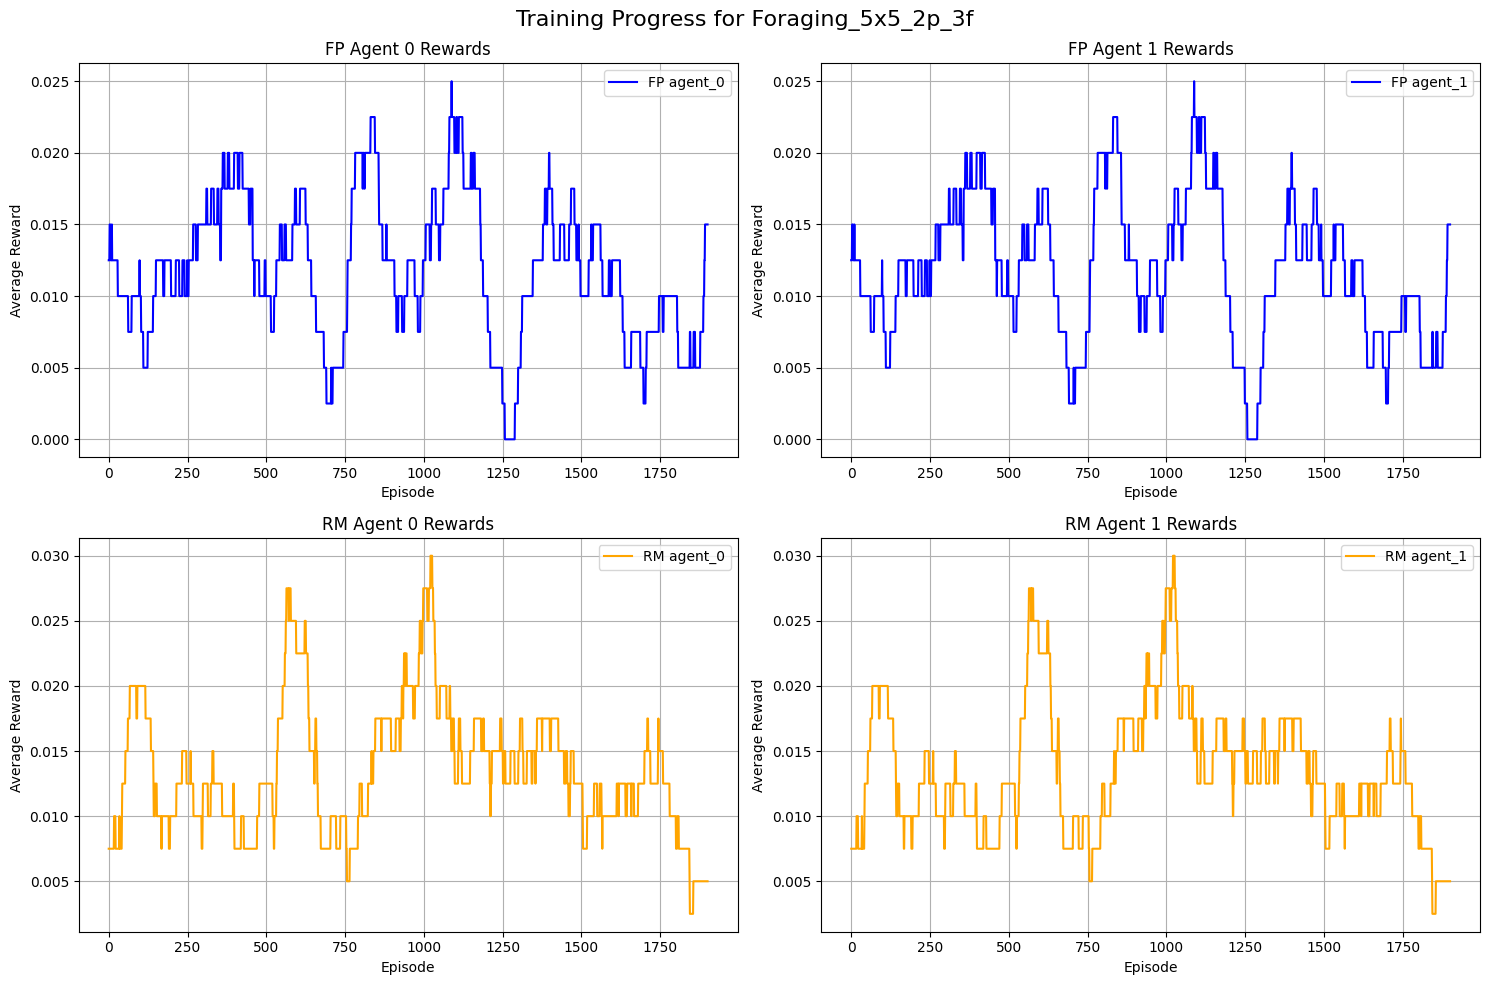


=== FINAL RESULTS FOR Foraging_5x5_2p_3f ===

FP final average rewards: [np.float64(0.015), np.float64(0.015)]
RM final average rewards: [np.float64(0.005), np.float64(0.005)]

=== LOADING AND PLOTTING TRAINING RESULTS ===

Loading results for RPS...


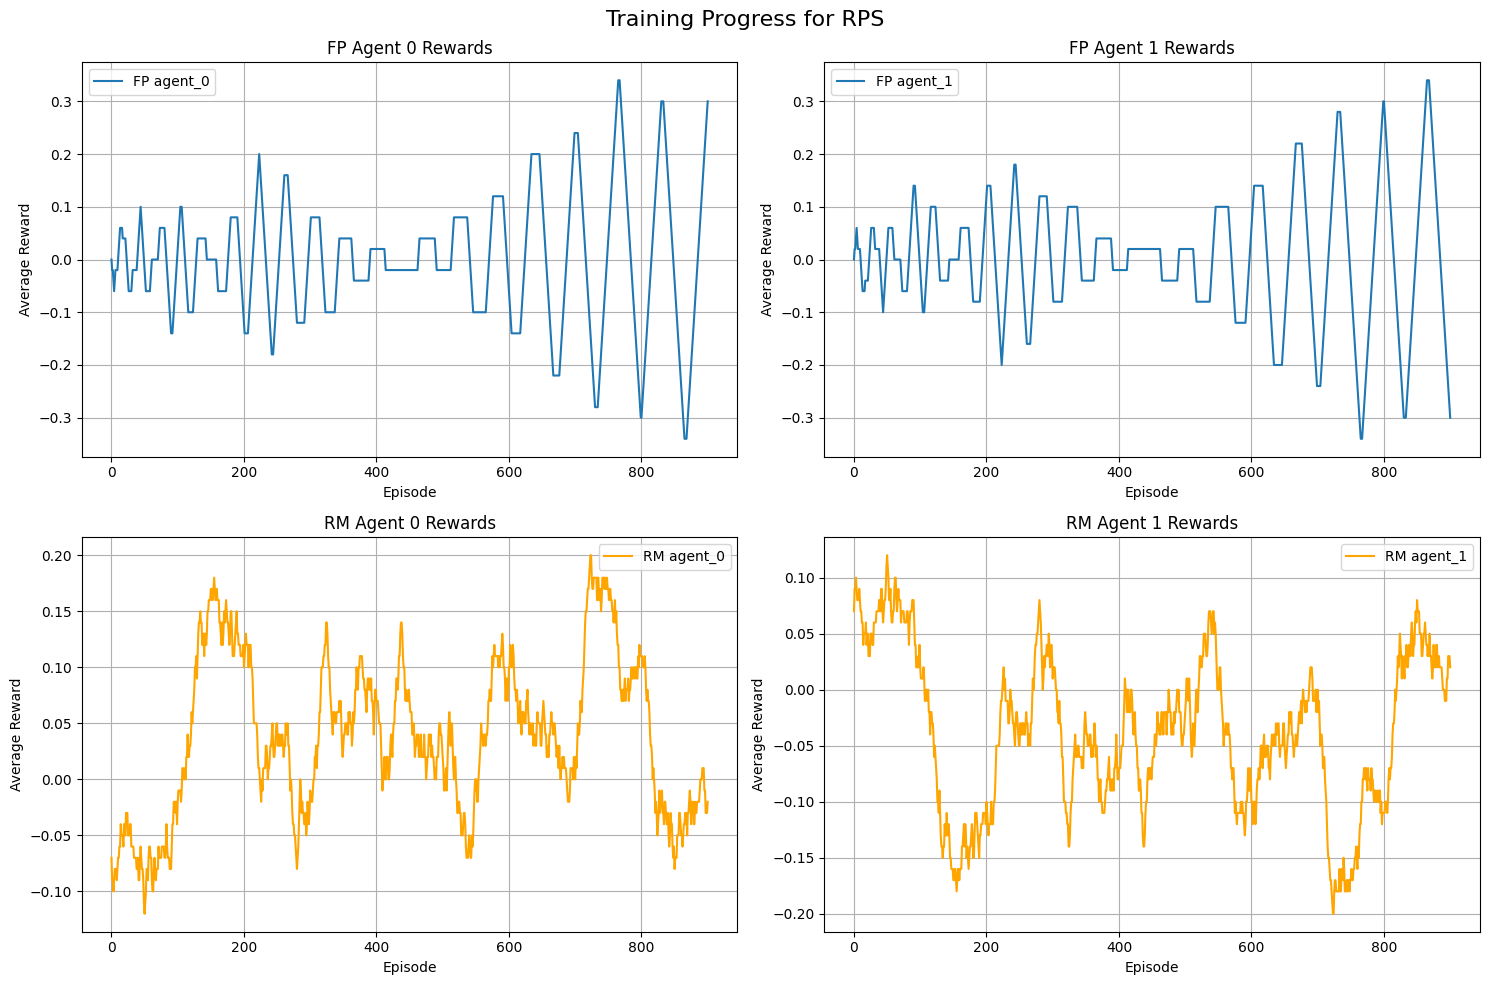


=== FINAL RESULTS FOR RPS ===

FP final average rewards: [np.float64(0.3), np.float64(-0.3)]
RM final average rewards: [np.float64(-0.02), np.float64(0.02)]
Loading results for MP...


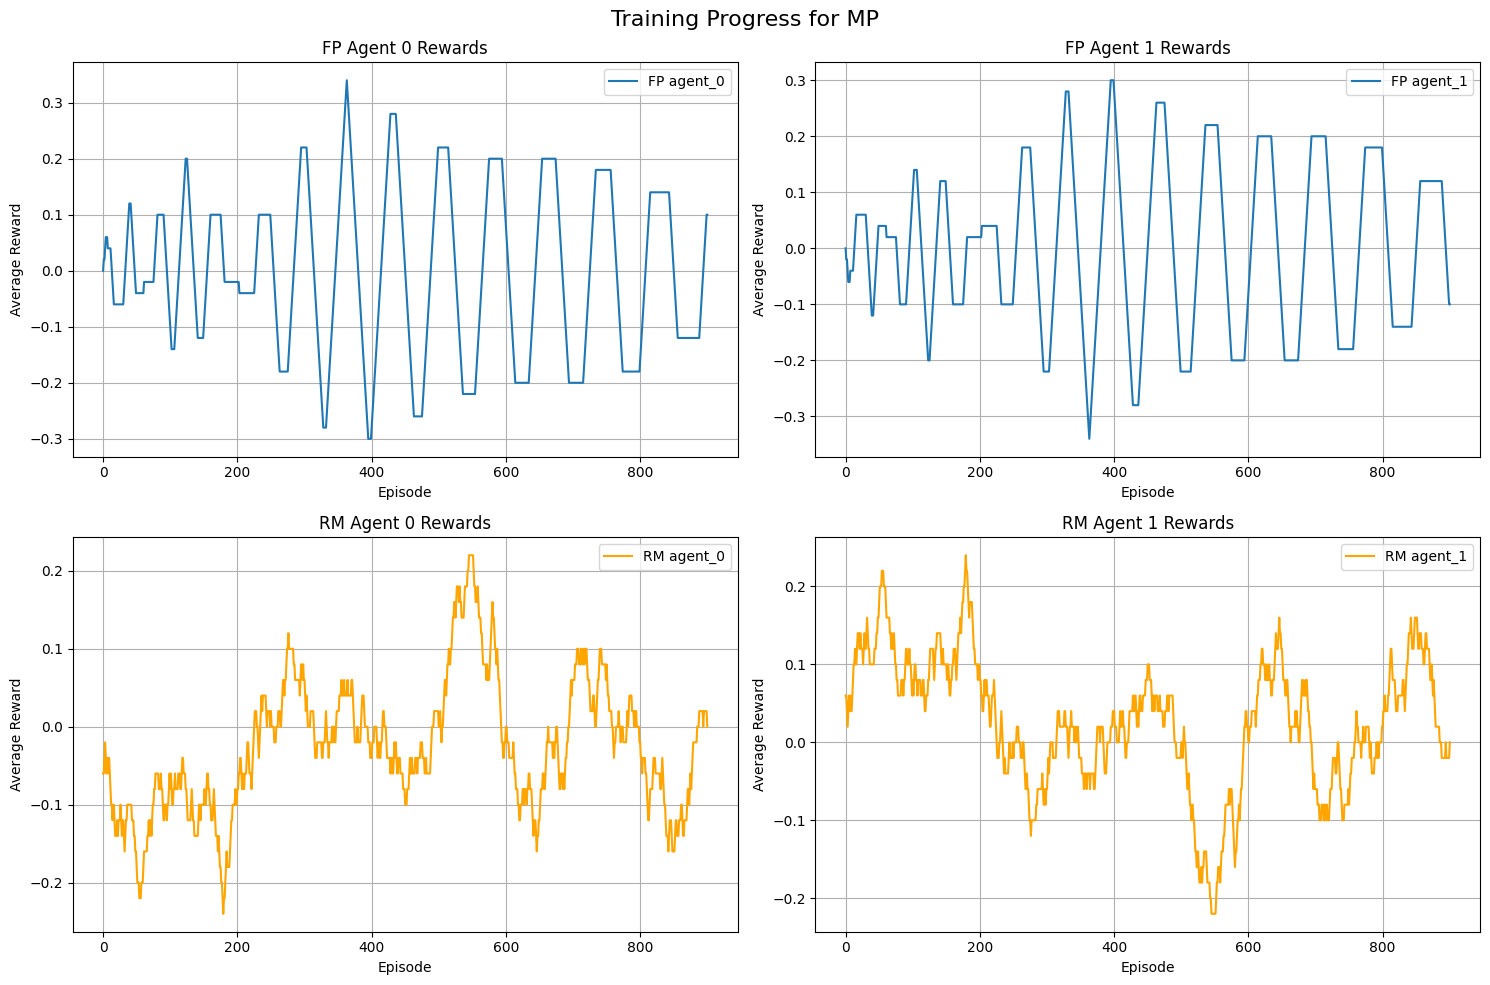


=== FINAL RESULTS FOR MP ===

FP final average rewards: [np.float64(0.1), np.float64(-0.1)]
RM final average rewards: [np.float64(0.0), np.float64(0.0)]
Training data not found for Blotto_S10_N5
  FP data exists: False
  RM data exists: False
Loading results for Foraging_5x5_2p_3f...


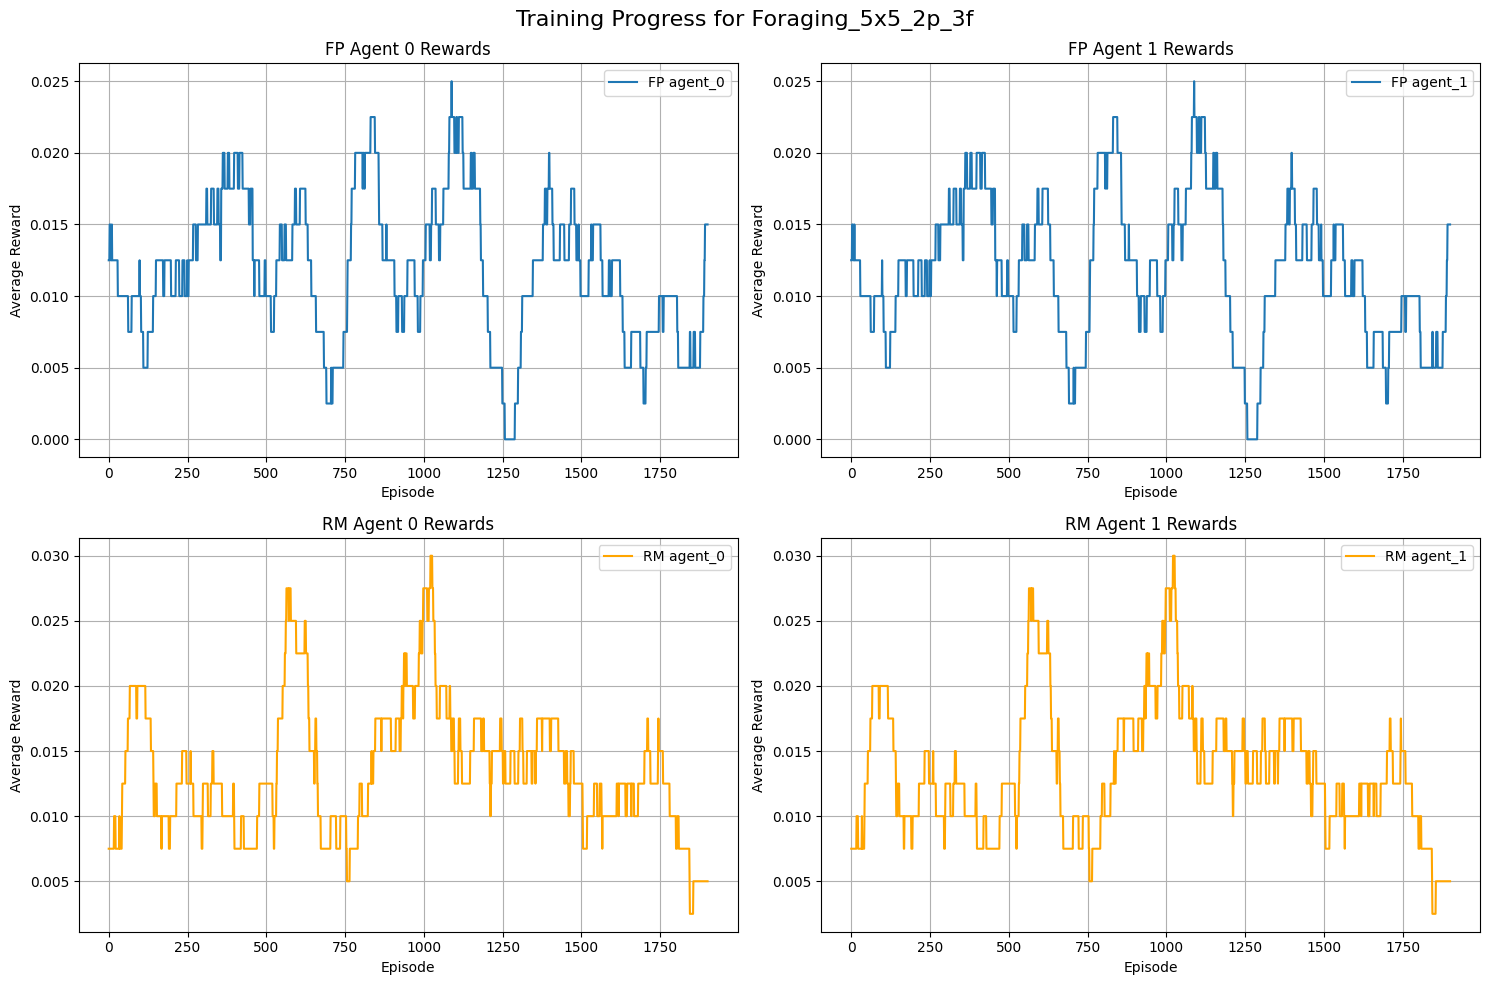


=== FINAL RESULTS FOR Foraging_5x5_2p_3f ===

FP final average rewards: [np.float64(0.015), np.float64(0.015)]
RM final average rewards: [np.float64(0.005), np.float64(0.005)]

=== TRAINING PIPELINE SETUP COMPLETED ===

To train specific games:
1. Uncomment the specific game training code above
2. Or run the comprehensive training loop in section 4

Training directories:
  FP models: fp_trainings
  RM models: rm_trainings

Games configured for training:
  0: RPS - 1000 episodes, 1 max steps
  1: MP - 1000 episodes, 1 max steps
  2: Blotto_S10_N5 - 2000 episodes, 1 max steps
  3: Foraging_5x5_2p_3f - 2000 episodes, 200 max steps


In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

def plot_training_results_fp_rm(game_name, base_path):
    """Graficar resultados de entrenamiento para agentes FP y RM para un juego específico."""
    fp_data_path = os.path.join(base_path, 'fp_trainings', game_name, 'fp_training_rewards.pkl')
    rm_data_path = os.path.join(base_path, 'rm_trainings', game_name, 'training_rewards_rm.pkl')
    
    fp_data_exists = os.path.exists(fp_data_path)
    rm_data_exists = os.path.exists(rm_data_path)
    
    if not fp_data_exists and not rm_data_exists:
        print(f"No se encontraron datos de entrenamiento para {game_name}")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Progreso de Entrenamiento para {game_name}', fontsize=16)
    
    if fp_data_exists:
        with open(fp_data_path, 'rb') as f:
            fp_rewards = pickle.load(f)
        
        for i, (agent_id, rewards) in enumerate(fp_rewards.items()):
            if i < 2:
                window = min(100, len(rewards) // 10)
                if len(rewards) >= window and window > 1:
                    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
                    axes[0, i].plot(moving_avg, label=f'FP {agent_id}', color='blue')
                else:
                    axes[0, i].plot(rewards, label=f'FP {agent_id}', color='blue')
                axes[0, i].set_title(f'Recompensas Agente FP {i}')
                axes[0, i].set_xlabel('Episodio')
                axes[0, i].set_ylabel('Recompensa Promedio')
                axes[0, i].legend()
                axes[0, i].grid(True)
    else:
        axes[0, 0].text(0.5, 0.5, 'No hay datos FP disponibles', ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 1].text(0.5, 0.5, 'No hay datos FP disponibles', ha='center', va='center', transform=axes[0, 1].transAxes)
    
    if rm_data_exists:
        with open(rm_data_path, 'rb') as f:
            rm_rewards = pickle.load(f)
        
        for i, (agent_id, rewards) in enumerate(rm_rewards.items()):
            if i < 2:
                window = min(100, len(rewards) // 10)
                if len(rewards) >= window and window > 1:
                    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
                    axes[1, i].plot(moving_avg, label=f'RM {agent_id}', color='orange')
                else:
                    axes[1, i].plot(rewards, label=f'RM {agent_id}', color='orange')
                axes[1, i].set_title(f'Recompensas Agente RM {i}')
                axes[1, i].set_xlabel('Episodio')
                axes[1, i].set_ylabel('Recompensa Promedio')
                axes[1, i].legend()
                axes[1, i].grid(True)
    else:
        axes[1, 0].text(0.5, 0.5, 'No hay datos RM disponibles', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 1].text(0.5, 0.5, 'No hay datos RM disponibles', ha='center', va='center', transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== RESULTADOS FINALES PARA {game_name} ===\n")
    if fp_data_exists:
        fp_final_rewards = [np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards) for rewards in fp_rewards.values()]
        print(f"Recompensas finales promedio FP: {fp_final_rewards}")
    if rm_data_exists:
        rm_final_rewards = [np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards) for rewards in rm_rewards.values()]
        print(f"Recompensas finales promedio RM: {rm_final_rewards}")

available_games = []
for game_entry in games_to_test:
    game_name = game_entry['name']
    fp_path = os.path.join('fp_trainings', game_name, 'fp_training_rewards.pkl')
    rm_path = os.path.join('rm_trainings', game_name, 'training_rewards_rm.pkl')
    if os.path.exists(fp_path) or os.path.exists(rm_path):
        available_games.append(game_name)

print(f"Se encontraron datos de entrenamiento para {len(available_games)} juegos: {available_games}")

for game_name in available_games:
    print(f"\nGraficando resultados para {game_name}...")
    plot_training_results_fp_rm(game_name, '.')

load_and_plot_all_training_results()

print("\n=== CONFIGURACIÓN DEL PIPELINE DE ENTRENAMIENTO COMPLETADA ===\n")
print("Para entrenar juegos específicos:")
print("1. Descomentar el código específico de entrenamiento del juego arriba")
print("2. O ejecutar el loop de entrenamiento comprensivo en la sección 4")
print("\nDirectorios de entrenamiento:")
print(f"  Modelos FP: {FP_TRAINING_DIR}")
print(f"  Modelos RM: {RM_TRAINING_DIR}")

print("\nJuegos configurados para entrenamiento:")
for i, game in enumerate(games_to_test):
    print(f"  {i}: {game['name']} - {game['train_episodes']} episodios, {game['max_steps']} máx pasos")